In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt

from utils.func_epinetmodel import define_epinet
from utils.func_makeinput import make_multiinput
from utils.func_pfm import read_pfm, write_pfm

# --- Configuration ---

# 1. Paths
# Path to trained weights file (.hdf5 or .keras)
MODEL_WEIGHTS_PATH = "models/checkpoints/iter0002_trainmse9.728_bp38.80.keras"

# Example: "data/hci_dataset/training/dino" or "data/lytro/2067"
INPUT_DIR = "data/hci_dataset/training/cotton"

# Directory to save the output PFM files
OUTPUT_DIR = "results"

# 2. Image Settings
# Set to 'synthetic' (512x512) or 'lytro' (552x383)
DATASET_TYPE = "synthetic"

# 3. View Settings
# "5x5" or "9x9"
VIEW_MODE = "9x9"

# --- Derived Parameters ---
if DATASET_TYPE.lower() == "synthetic":
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512
elif DATASET_TYPE.lower() == "lytro":
    IMAGE_HEIGHT = 383
    IMAGE_WIDTH = 552
else:
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512

if VIEW_MODE == "9x9":
    ANGULAR_VIEWS = [0, 1, 2, 3, 4, 5, 6, 7, 8]
else:
    ANGULAR_VIEWS = [2, 3, 4, 5, 6]

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(
    f"Configuration Set:\nType: {DATASET_TYPE} ({IMAGE_WIDTH}x{IMAGE_HEIGHT})\nViews: {VIEW_MODE}\nWeights: {MODEL_WEIGHTS_PATH}"
)

2026-01-05 23:37:42.320975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Configuration Set:
Type: synthetic (512x512)
Views: 9x9
Weights: models/checkpoints/iter0002_trainmse9.728_bp38.80.keras


/home/tiberiu/Documents/TAID/FC/epinet/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# 1. Build Model
print("Building Model...")
model = define_epinet(
    sz_input_h=IMAGE_HEIGHT,
    sz_input_w=IMAGE_WIDTH,
    view_n=ANGULAR_VIEWS,
    conv_depth=7,
    filt_num=70,
    learning_rate=0.1e-3,
)

# 2. Load Weights
print(f"Loading weights from: {MODEL_WEIGHTS_PATH}")
try:
    model.load_weights(MODEL_WEIGHTS_PATH)
except OSError:
    print("Error: Weight file not found. Check the path in Cell 1.")
    raise

# 3. Prepare Input
print(f"Processing directory: {INPUT_DIR}")
try:
    # Prepare 4-stream input (90d, 0d, 45d, -45d)
    (val_90d, val_0d, val_45d, val_m45d) = make_multiinput(
        INPUT_DIR, IMAGE_HEIGHT, IMAGE_WIDTH, ANGULAR_VIEWS
    )
except NameError:
    print("Error: make_multiinput not defined. Check imports in Cell 3.")
    raise

# 4. Predict
print("Running prediction...")
start_time = time.perf_counter()

pred_output = model.predict(
    [val_90d, val_0d, val_45d, val_m45d], batch_size=1, verbose=1
)

runtime = time.perf_counter() - start_time
print(f"Prediction complete in {runtime:.4f} seconds.")

# 5. Save Output
output_filename = f"{Path(INPUT_DIR).name}.pfm"
output_path = Path(OUTPUT_DIR) / output_filename
disparity_map = pred_output[0, :, :, 0]

write_pfm(disparity_map, str(output_path))
print(f"Saved disparity map to: {output_path}")

/home/tiberiu/Documents/TAID/FC/epinet/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1767649063.623273  389308 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2597 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Building Model...


Model: "functional_102"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_stack_90d     │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stack_0d      │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stack_45d     │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stack_M45d    │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 506, 506,  │    101,780 │ input_stack_90d[… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 506, 506,  │    101,780 │ input_stack_0d[0… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 506, 506,  │    101,780 │ input_stack_45d[… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 506, 506,  │    101,780 │ input_stack_M45d… │
│ (Sequential)        │ 70)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_merged          │ (None, 506, 506,  │          0 │ sequential[0][0], │
│ (Concatenate)       │ 280)              │            │ sequential_1[0][… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 492, 492,  │  4,402,160 │ mid_merged[0][0]  │
│ (Sequential)        │ 280)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 490, 490,  │    315,001 │ sequential_4[0][… │
│ (Sequential)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,124,281 (19.55 MB)

 Trainable params: 5,118,681 (19.53 MB)

 Non-trainable params: 5,600 (21.88 KB)

Loading weights from: models/checkpoints/iter0002_trainmse9.728_bp38.80.keras


/home/tiberiu/Documents/TAID/FC/epinet/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 120 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Processing directory: data/hci_dataset/training/cotton
Running prediction...


2026-01-05 23:37:46.168938: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f03c00037a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-05 23:37:46.168954: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2026-01-05 23:37:46.192361: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-05 23:37:46.580421: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-05 23:37:52.697653: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng13{} for conv (f32[1,280,505,505]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,280,506,506]{3,2,1,0}, f32[280,280,2,2]{3,2,1,0}, f32[280]{0}), window={size=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", 

1/1 ━━━━━━━━━━━━━━━━━━━━ 73s 73s/step
Prediction complete in 72.9345 seconds.
=
Saved disparity map to: results/cotton.pfm


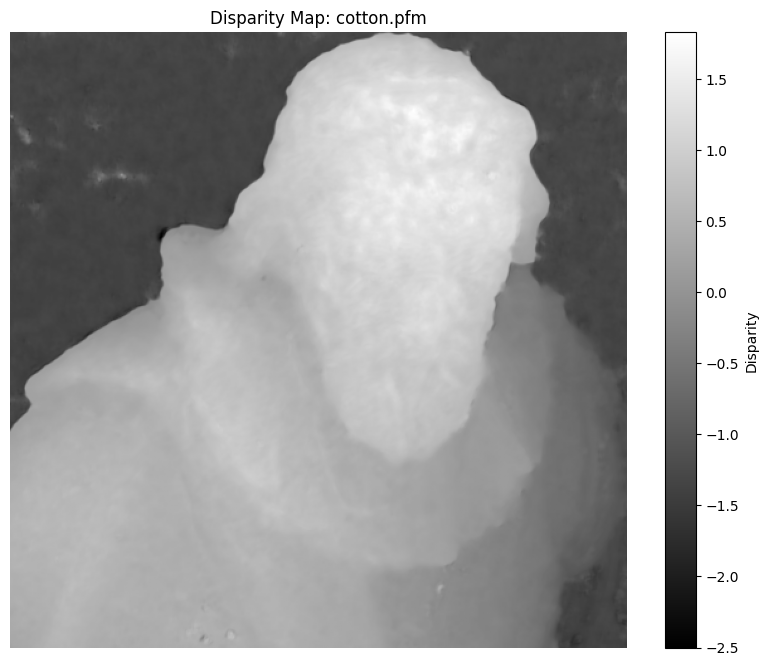

In [3]:
output_path = Path(OUTPUT_DIR) / f"{Path(INPUT_DIR).name}.pfm"

if output_path.exists():
    try:
        disparity_data = read_pfm(str(output_path), expected_identifier="Pf")

        plt.figure(figsize=(10, 8))
        plt.imshow(disparity_data, cmap="gray")
        plt.colorbar(label="Disparity")
        plt.title(f"Disparity Map: {output_path.name}")
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"Error reading PFM: {e}")
        print("Retrying with expected_identifier='PF' (Color)...")
        try:
            disparity_data = read_pfm(str(output_path), expected_identifier="PF")
            plt.imshow(disparity_data)
            plt.show()
        except Exception as e2:
            print(f"Retry failed: {e2}")
else:
    print(f"Output file not found at {output_path}. Run the prediction cell first.")